In [1]:
import math
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
%matplotlib inline
import yfinance as yf
from statsmodels.graphics.tsaplots import plot_acf
from scipy.optimize import minimize
from numba import njit

# plot styling
plt.style.use('seaborn-darkgrid')
plt.rcParams['font.family'] = 'DIN Alternate' # 'HP Simplified Jpan'
plt_dpi = 500 # change to 500

In [2]:
def to_binary(a):
  l,m=[],[]
  for i in a:
    l.append(ord(i))
  for i in l:
    m.append(int(bin(i)[2:]))
  return m

In [3]:
np_seed = np.sum(to_binary('Lite kanske nervös, hoppas på G'))

In [4]:
# pretty print skewness and kurtosis
def get_moments(log_ret):
    """ 
    Input: Log returns
    Output: Skewness and kurtosis
    """
    d = {
        'Skewness': log_ret.skew(),
        'Kurtosis': log_ret.kurtosis()   
    }
    return pd.DataFrame(data=d)

In [5]:
# pretty print volatility of log-returns
def get_volatility(log_ret):
    """ 
    Input: Log returns
    Output: Volatility - daily, monthly, annually
    """
    daily_vol = log_ret.std()
    d = {
        'Daily': daily_vol,
        'Monthly': np.sqrt(21) * daily_vol,
        'Annually': np.sqrt(252) * daily_vol
    }
    return pd.DataFrame(data=d)

In [6]:
# fetch stock data from yfinance and convert to log returns
def get_data(ticker_id, start, end):
    """
    Input: Ticker ID, start date, end date
    Output: Log returns as pd.DataFrame 
    """
    dat = yf.Ticker(ticker_id).history(start=start, end=end)
    closing_price = dat[['Close']]
    log_ret = np.log(closing_price).diff().dropna()
    log_ret.columns = [' '.join(['Log returns', ticker_id])]
    return log_ret

In [7]:
# concatenate multiple log returns
def concat_returns(ret_obj):
    """ 
    Input: Dict including ticker IDs, start date
           and end date
    Output: Concatenated log returns
    """
    start = ret_obj['start_date']
    end = ret_obj['end_date']
    l = list()
    for t in ret_obj['tickers']:
        dat = get_data(t, start, end)
        l.append(dat)
    return pd.concat(l, axis=1)

In [8]:
def cov2cor(covariance):
    v = np.sqrt(np.diag(covariance))
    outer_v = np.outer(v, v)
    correlation = covariance / outer_v
    correlation[covariance == 0] = 0
    return correlation

# Computer Assignment 2
## Multivariate Time Series Modeling

## 1. Daily correlation forecast using EWMA

In [9]:
def ewma_recursion(y, lbd, sigma):
    """
    Input: Log return y, lambda lbd and
           covariance matrix sigma.
    Output: Volatility forecast next day 
    """
    ret = (1 - lbd) * np.matmul(y.T, y) + lbd * sigma
    return ret

In [10]:
def mv_ewma(init_cov, Y, dim):
    """
    Input: Initial covariance, log returns Y for 3 assets
           and the dimension. 
    Output: The correlation forecast for the 3 assets during
            dim days.
    """
    sig = np.zeros((dim, 3, 3))
    cor = np.zeros((dim, 3))
    sig[0] = init_cov
    init_cor = cov2cor(init_cov)
    cor[0] = init_cor.flatten()[[1, 2, 5]]
    for i in np.arange(1, dim):
        y = Y[i - 1, :]
        sig[i] = ewma_recursion(y, lbd, sig[i - 1])
        cor_mat = cov2cor(sig[i])
        cor[i, :] = cor_mat.flatten()[[1, 2, 5]]
    return cor

In [11]:
# import data
ret_info = {
    'tickers': ['CAT', 'JPM', 'WMT'],
    'start_date': '2007-01-01',
    'end_date': '2020-12-31'
}
dat_ewma = concat_returns(ret_info)

In [12]:
# check dim and content
print(dat_ewma.shape)
dat_ewma.head()

(3523, 3)


,Log returns CAT,Log returns JPM,Log returns WMT
Date,,,
2007-01-04,-0.002619,0.002493,0.004825
2007-01-05,-0.012869,-0.008335,-0.008196
2007-01-08,0.001162,0.003342,-0.008264
2007-01-09,0.005458,-0.004180,0.008264
2007-01-10,-0.004961,0.007303,-0.002324


In [13]:
# get calibration data
dat_cal = dat_ewma.loc[:'2017-01-01']

# get initial covariance 
init_cov = np.cov(dat_cal.values.T)

In [14]:
# daily EWMA simplified (formula)
lbd = .94  
dim = dat_ewma.shape[0]
Y = dat_ewma.values.reshape(dim, 1, 3)
dat_ewma[['CAT vs. JPM', 'CAT vs. WMT', 'JPM vs. WMT']] = mv_ewma(init_cov, Y, dim)

findfont: Font family ['DIN Alternate'] not found. Falling back to DejaVu Sans.


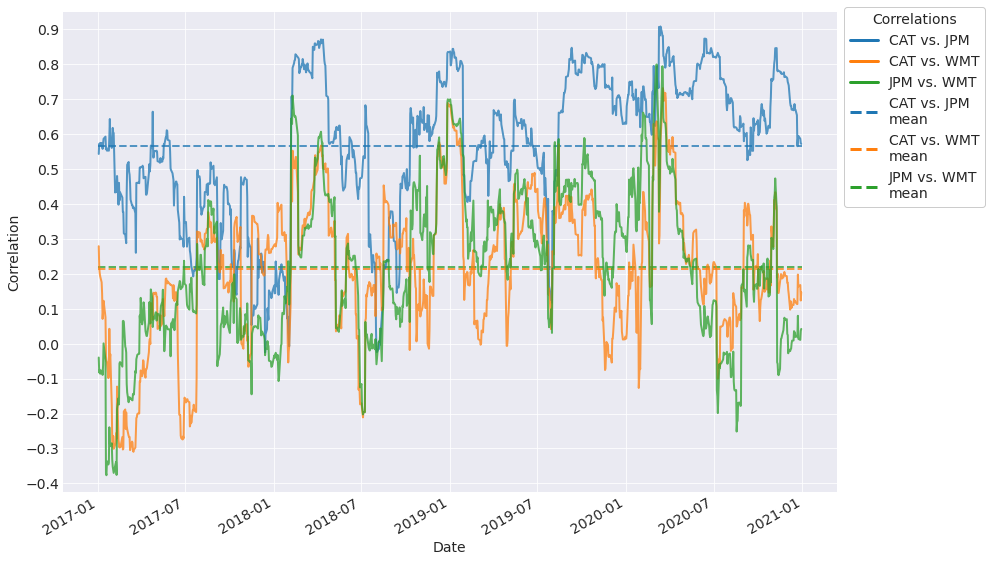

In [15]:
# visualize the correlatione forecast for the assets
plt.rcParams.update({'font.size': 14})
fcst = dat_ewma[['CAT vs. JPM', 'CAT vs. WMT', 'JPM vs. WMT']].loc['2017-01-01':]
fcst.plot(
    figsize=(14, 8),
    alpha=.75,
    linewidth=2
)

mean_corr = fcst.mean(axis=0).values
plt.hlines(
    mean_corr,
    xmin='2017-01-01',
    xmax='2020-12-31',
    linestyles='dashed',
    color=['#1f77b4', '#ff7f0e', '#2ca02c'],
    linewidth=2,
    alpha=.75
)

colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
corr_lines = [Line2D([0], [0], color=c, linewidth=3, linestyle='solid') for c in colors]
lines = [Line2D([0], [0], color=c, linewidth=3, linestyle='dashed') for c in colors]
labels = [
    'CAT vs. JPM', 'CAT vs. WMT', 'JPM vs. WMT',
    'CAT vs. JPM\nmean', 'CAT vs. WMT\nmean', 'JPM vs. WMT\nmean'
]
plt.legend(
    corr_lines + lines, labels, loc='upper left',
    frameon=1, framealpha=1, facecolor='white',
    bbox_to_anchor=(1., 1.025),
    title='Correlations'
)

plt.yticks(np.arange(-.4, 1.1, .1))
plt.ylim([-.425, .95])
plt.ylabel('Correlation')
plt.tight_layout()
plt.savefig('plot/1.png', dpi=plt_dpi, bbox_inches='tight')

## 2. Explore the weekly data set

In [16]:
# import data
market_data = pd.read_csv(
    'market_data.csv',
    sep=';',
    index_col='Date'
)
market_data.head()

,BA,CAT,KO,DIS,JPM,MMM,MSFT,PFE,WMT,XOM,Y05,Y10,Y15,Y20,Y30
Date,,,,,,,,,,,,,,,
1996-01-12,23.880095,7.515185,9.671157,15.032939,8.997881,16.280800,3.389680,4.436570,7.321428,9.170008,0.054244,0.058680,0.061677,0.063527,0.064956
1996-01-19,24.072056,7.628633,9.754246,15.032939,9.624698,15.685932,3.631800,4.463621,6.539931,9.342750,0.052575,0.056656,0.059565,0.061497,0.063324
1996-01-26,23.572945,8.048860,9.903805,15.220852,10.190859,16.343416,3.577445,4.752179,6.581061,9.184401,0.053543,0.057674,0.060444,0.062219,0.063787
1996-02-02,23.956881,8.194318,9.986889,15.534030,10.554815,16.437353,3.676270,4.896458,7.074640,9.299567,0.052543,0.057912,0.061402,0.063482,0.064930
1996-02-09,25.456841,8.355941,10.585104,15.721951,10.817680,17.126156,3.957922,4.990695,7.362562,9.603882,0.052428,0.058077,0.061642,0.063650,0.064762


### a) Explore evolution

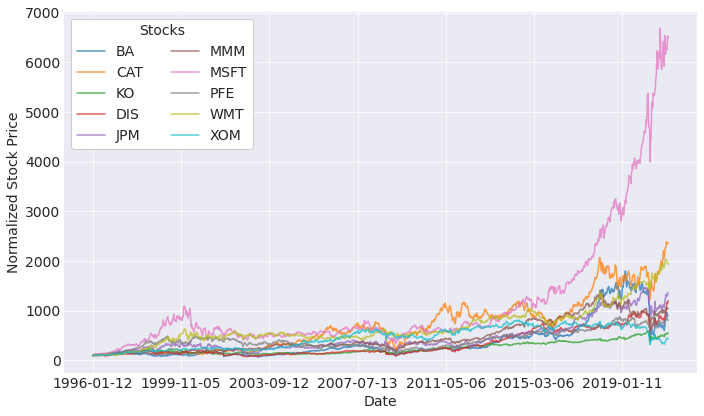

In [17]:
# plot the normalized stock price evolution
plt.rcParams.update({'font.size': 14})
stocks = market_data.iloc[:, :-5]
nrm = (100 / stocks.iloc[0, :].values).reshape(1, 10)
stocks_n = stocks * nrm
stocks_n.plot(
    figsize=(10, 6),
    alpha=.75
)
plt.legend(frameon=1, framealpha=1, facecolor='white', ncol=2, title='Stocks')
plt.ylabel('Normalized Stock Price')
plt.tight_layout()
plt.savefig('plot/2a_stocks.png', dpi=plt_dpi)

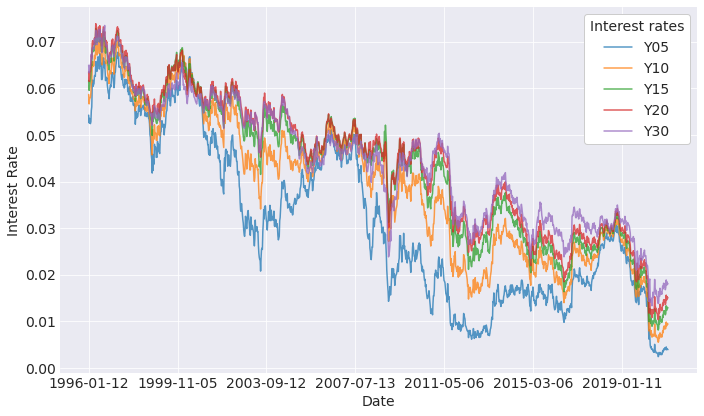

In [18]:
# plot the evolution of the interest rates
rates = market_data.iloc[:, -5:]
rates.plot(
    figsize=(10, 6),
    alpha=.75
)
plt.legend(frameon=1, framealpha=1, facecolor='white', title='Interest rates')
plt.ylabel('Interest Rate')
plt.tight_layout()
plt.savefig('plot/2a_rates.png', dpi=plt_dpi)

### b) Stock calculations

In [19]:
log_ret = np.log(stocks).diff().dropna()
ann_mean_log = 52 * log_ret.mean()
ann_vol = np.sqrt(52) * log_ret.std()
stock_tab = log_ret.describe([.05, .95]).T.iloc[:, 3:]
stock_tab['Annualized Mean'] = ann_mean_log.values
stock_tab['Annualized Volatility'] = ann_vol.values
stock_tab = stock_tab.drop(columns=['50%']).round(3)
stock_tab

,min,5%,95%,max,Annualized Mean,Annualized Volatility
BA,-0.583,-0.071,0.071,0.534,0.088,0.382
CAT,-0.225,-0.074,0.076,0.269,0.126,0.330
KO,-0.236,-0.046,0.049,0.112,0.068,0.229
DIS,-0.277,-0.058,0.064,0.163,0.099,0.284
JPM,-0.417,-0.076,0.073,0.399,0.104,0.370
MMM,-0.174,-0.053,0.051,0.160,0.094,0.234
MSFT,-0.211,-0.060,0.068,0.210,0.166,0.291
PFE,-0.227,-0.052,0.058,0.133,0.083,0.256
WMT,-0.160,-0.053,0.055,0.168,0.118,0.245
XOM,-0.224,-0.050,0.051,0.155,0.058,0.231


In [20]:
# for report use only
print(stock_tab.to_latex())

\begin{tabular}{lrrrrrr}
\toprule
{} &    min &     5\% &    95\% &    max &  Annualized Mean &  Annualized Volatility \\
\midrule
BA   & -0.583 & -0.071 &  0.071 &  0.534 &            0.088 &                  0.382 \\
CAT  & -0.225 & -0.074 &  0.076 &  0.269 &            0.126 &                  0.330 \\
KO   & -0.236 & -0.046 &  0.049 &  0.112 &            0.068 &                  0.229 \\
DIS  & -0.277 & -0.058 &  0.064 &  0.163 &            0.099 &                  0.284 \\
JPM  & -0.417 & -0.076 &  0.073 &  0.399 &            0.104 &                  0.370 \\
MMM  & -0.174 & -0.053 &  0.051 &  0.160 &            0.094 &                  0.234 \\
MSFT & -0.211 & -0.060 &  0.068 &  0.210 &            0.166 &                  0.291 \\
PFE  & -0.227 & -0.052 &  0.058 &  0.133 &            0.083 &                  0.256 \\
WMT  & -0.160 & -0.053 &  0.055 &  0.168 &            0.118 &                  0.245 \\
XOM  & -0.224 & -0.050 &  0.051 &  0.155 &            0.058 &                

### c) Correlation matrix plot

In [21]:
# correlation matrix computation
cor_mat = np.log(market_data).diff().dropna().corr()

findfont: Font family ['DIN Alternate'] not found. Falling back to DejaVu Sans.


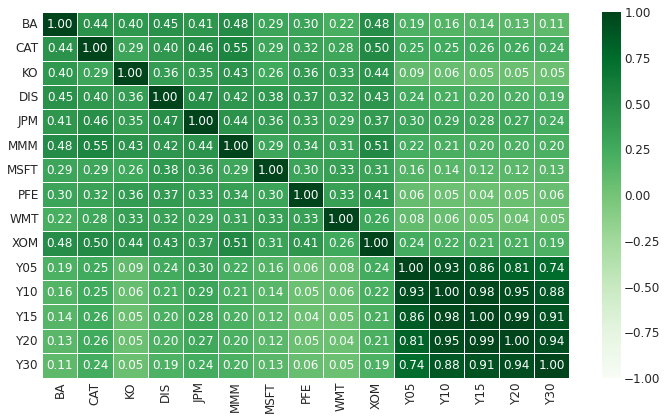

In [22]:
# plot correlations
plt.rcParams.update({'font.size': 12})
fig, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(
    cor_mat,
    vmin=-1,
    vmax=1,
    cmap='Greens',
    annot=True,
    fmt='.2f', 
    linewidths=.5,
    ax=ax,
    annot_kws={'color': 'white'}
)
plt.tight_layout()
plt.savefig('plot/2c.png', dpi=plt_dpi)

## 3. VAR(1)-model

In [23]:
# compute weekly log returns for all assets
log_market_data = np.log(market_data).diff().dropna()
log_market_data.head()

,BA,CAT,KO,DIS,JPM,MMM,MSFT,PFE,WMT,XOM,Y05,Y10,Y15,Y20,Y30
Date,,,,,,,,,,,,,,,
1996-01-19,0.008006,0.014983,0.008555,0.000000,0.067343,-0.037222,0.068993,0.006079,-0.112879,0.018662,-0.031262,-0.035090,-0.034838,-0.032477,-0.025440
1996-01-26,-0.020952,0.053622,0.015216,0.012423,0.057159,0.041061,-0.015080,0.062643,0.006269,-0.017094,0.018247,0.017794,0.014648,0.011665,0.007288
1996-02-02,0.016156,0.017911,0.008354,0.020367,0.035091,0.005731,0.027250,0.029909,0.072320,0.012461,-0.018850,0.004124,0.015726,0.020090,0.017763
1996-02-09,0.060729,0.019532,0.058175,0.012025,0.024600,0.041051,0.073820,0.019063,0.039891,0.032200,-0.002187,0.002845,0.003900,0.002648,-0.002603
1996-02-16,-0.012177,0.036092,0.010929,0.021676,0.012999,-0.027806,-0.022729,-0.012785,-0.051588,-0.013710,0.007670,0.016454,0.019769,0.020086,0.016799


### a) Estimate parameters and check stability

In [24]:
# check dimension
log_market_data.shape

(1304, 15)

In [25]:
# create 'M' matrix
dim = log_market_data.shape[0] - 1
intercept = np.ones((dim, 1))
M = np.concatenate((intercept, log_market_data.values[:-1, :]), axis=1)
M.shape

(1303, 16)

In [26]:
# estimate parameter matrix 'A'
K = log_market_data.shape[1]
Y = log_market_data.values[1:, :]
B = np.linalg.lstsq(M, Y, rcond=None)[0].T # least squares
# B = (np.linalg.inv(M.T @ M) @ M.T @ Y).T # normal equation
A0 = B[:, 0].reshape((K, 1))
A1 = B[:, 1:]
print(B.shape, A0.shape, A1.shape)

(15, 16) (15, 1) (15, 15)


In [27]:
# compute residuals for each period
Y_init = log_market_data.values[:-1, :].T
resid = Y.T - (A0 + A1 @ Y_init)
resid.shape

(15, 1303)

In [28]:
Y_init.shape
Y.shape

(1303, 15)

In [29]:
# compute covariance of residuals
resid_cov = np.cov(resid)
resid_cov.shape

(15, 15)

In [30]:
# compute eigenvalues and -vectors
e, v = np.linalg.eig(A1)

findfont: Font family ['DIN Alternate'] not found. Falling back to DejaVu Sans.


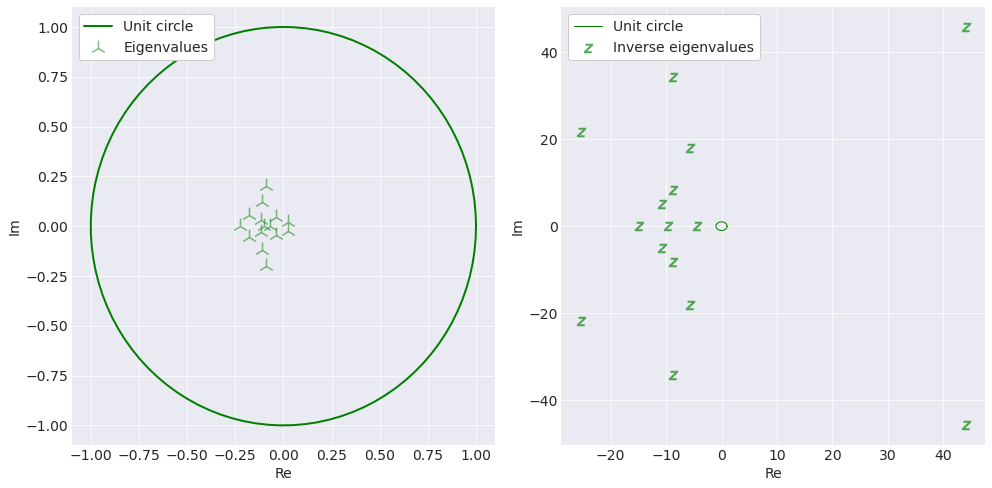

In [31]:
plt.rcParams["figure.figsize"] = (14, 7)
plt.rcParams.update({'font.size': 14})
f, (ax1, ax2) = plt.subplots(1, 2)
t = np.linspace(0, 2*np.pi, 100) # unit circle values

# visualize eigenvalues
ax1.scatter(e.real, e.imag, color='green', alpha=.5, marker='2', s=250, label='Eigenvalues')
ax1.plot(np.cos(t), np.sin(t), linewidth=2, color='green', label='Unit circle')
ax1.set_xlabel('Re')
ax1.set_ylabel('Im')
ax1.legend(frameon=1, facecolor='white', framealpha=1, loc='upper left')

# visualize inverse of eigenvalues
z_real = np.divide(1, e.real, out=np.zeros_like(e.real), where=e.real!=0)
z_imag = np.divide(1, e.imag, out=np.zeros_like(e.imag), where=e.imag!=0)

ax2.scatter(z_real, z_imag, color='green', alpha=.5, marker='$z$', s=75, label='Inverse eigenvalues')
ax2.plot(np.cos(t), np.sin(t), linewidth=1, color='green', label='Unit circle')
ax2.set_xlabel('Re')
ax2.set_ylabel('Im')
ax2.legend(frameon=1, facecolor='white', framealpha=1, loc='upper left')

plt.tight_layout()
plt.savefig('plot/3a.png', dpi=plt_dpi)
plt.show()

In [32]:
# for report use only
print(pd.DataFrame(B).round(4).to_latex(index=False, header=False))

\begin{tabular}{rrrrrrrrrrrrrrrr}
\toprule
 0.0020 & -0.0975 &  0.1381 & -0.0237 & -0.0047 & -0.0682 & -0.1290 & -0.0126 & -0.0143 & -0.0232 &  0.1040 &  0.7991 & -5.2426 & 10.5167 & -7.2155 &  1.1929 \\
 0.0022 &  0.0173 & -0.0059 & -0.0285 &  0.0222 & -0.0213 &  0.0357 &  0.0500 & -0.0456 &  0.0484 & -0.0618 &  0.2277 & -1.3776 &  2.4934 & -1.6469 &  0.2693 \\
 0.0015 &  0.0208 &  0.0565 & -0.0568 & -0.0179 & -0.0204 & -0.0975 & -0.0166 &  0.0344 & -0.0587 &  0.0872 &  0.3506 & -2.1838 &  4.0001 & -2.6218 &  0.4520 \\
 0.0018 &  0.0300 &  0.0492 & -0.0105 & -0.0756 &  0.0025 &  0.0527 & -0.0425 &  0.0010 &  0.0423 & -0.0167 &  0.2360 & -1.8513 &  3.9882 & -2.8729 &  0.4934 \\
 0.0017 &  0.0161 &  0.0616 &  0.0110 &  0.0345 & -0.1892 & -0.0178 &  0.0674 &  0.0734 &  0.0655 & -0.0324 &  0.4253 & -2.4988 &  4.9189 & -3.3306 &  0.4344 \\
 0.0020 &  0.0354 &  0.1029 &  0.0323 & -0.0372 & -0.0775 & -0.1178 & -0.0371 &  0.0221 &  0.0143 & -0.0303 &  0.2164 & -1.2966 &  2.1004 & -1.1395 &  0

### b) Compute volatilities of the VAR-residuals

In [33]:
# compute volatility of residuals
resid_df = pd.DataFrame(resid.T, columns=list(market_data.columns))
vol_df = pd.DataFrame(resid_df.std())
vol_df.columns = ['Volatility']
vol_df

,Volatility
BA,0.051097
CAT,0.045500
KO,0.031040
DIS,0.038983
JPM,0.050176
MMM,0.031640
MSFT,0.040063
PFE,0.035134
WMT,0.033012
XOM,0.031283


In [34]:
# for report use only
print(vol_df.to_latex(position='H', caption='Caption', label='tab:3b'))

\begin{table}[H]
\centering
\caption{Caption}
\label{tab:3b}
\begin{tabular}{lr}
\toprule
{} &  Volatility \\
\midrule
BA   &    0.051097 \\
CAT  &    0.045500 \\
KO   &    0.031040 \\
DIS  &    0.038983 \\
JPM  &    0.050176 \\
MMM  &    0.031640 \\
MSFT &    0.040063 \\
PFE  &    0.035134 \\
WMT  &    0.033012 \\
XOM  &    0.031283 \\
Y05  &    0.060374 \\
Y10  &    0.044642 \\
Y15  &    0.037710 \\
Y20  &    0.034141 \\
Y30  &    0.032911 \\
\bottomrule
\end{tabular}
\end{table}



### c) Simulate VAR(1)

In [35]:
# compute VAR(1) recursions
@njit
def VAR(B, Z, C, Y0, P0, n_scenarios=2000, n_weeks=480):
    log_mat = np.zeros((n_scenarios, n_weeks, Y0.shape[0], 1)) # log returns
    p_mat = np.zeros((n_scenarios, n_weeks, Y0.shape[0], 1)) # prices
    A0, A1 = B
    for s in np.arange(n_scenarios):
        log_mat[s, 0] =  A0 + A1 @ Y0 + C @ Z[s, 0]
        p_mat[s, 0] = np.exp(log_mat[s, 0]) * P0
        for w in np.arange(n_weeks - 1):
            log_mat[s, w + 1] = A0 + A1 @ log_mat[s, w] + C @ Z[s, w + 1]
            p_mat[s, w + 1] =  np.exp(log_mat[s, w + 1]) * p_mat[s, w]

    return log_mat, p_mat

In [36]:
# set seed for reproducibility
np.random.seed(np_seed)

n_s = 2000 # number of scenarios
n_w = 480 # number of weeks
Y0 = log_market_data.values[-1, :].reshape((15, 1)).copy() # initial returns
P0 = market_data.values[-1, :].reshape((15, 1)).copy()
B = (A0.copy(), A1.copy())

K = Y0.shape[0] # number of assets
C = np.linalg.cholesky(resid_cov) # cholesky factor
Z = np.random.standard_normal((n_s, n_w, K, 1)) # standard-normal matrix

sim_log, sim_p = VAR(B, Z, C, Y0, P0)
print(sim_log.shape)
print(sim_p.shape)

(2000, 480, 15, 1)
(2000, 480, 15, 1)


In [37]:
# get index for requested assets
V_prct = dict() # dict including each asset
asset_labels = ['CAT', 'WMT', 'Y05', 'Y30']
col_name_idx = np.isin(log_market_data.columns,  asset_labels)
prc_dat = sim_p[:, :, col_name_idx]
qnts = [5, 10, 25, 50, 75, 90, 95]
df_labels = ['5%', '10%', '25%', '50%', '75%', '90%', '95%']
for i in np.arange(np.sum(col_name_idx)):
    d = prc_dat[:, :, i].reshape((n_s, n_w))
    V_prct[asset_labels[i]] = pd.DataFrame(
        np.percentile(d, q=qnts, axis=0),
        columns=np.arange(1, n_w + 1),
        index=df_labels
    )

findfont: Font family ['DIN Alternate'] not found. Falling back to DejaVu Sans.


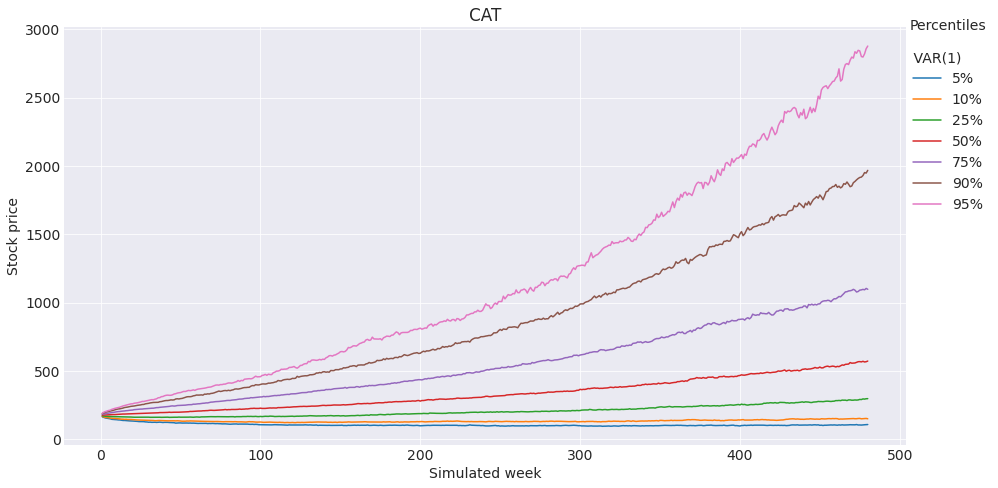

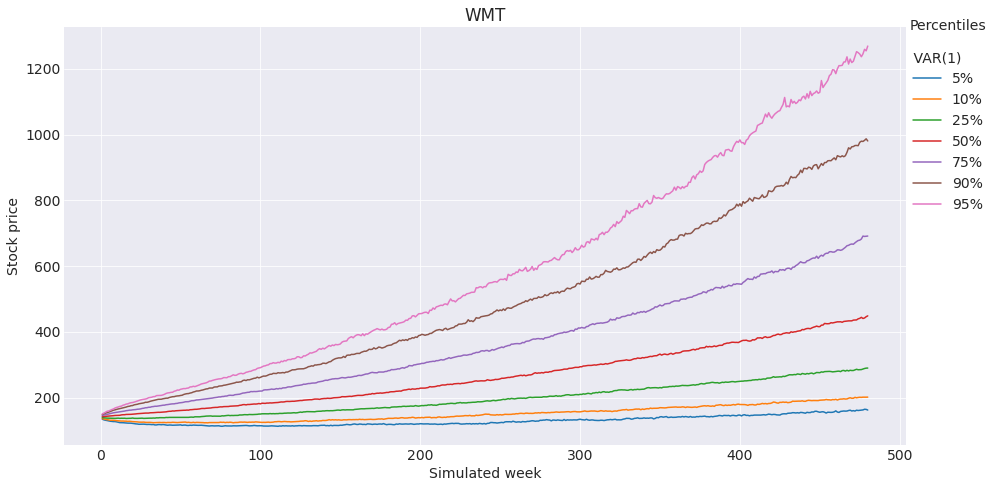

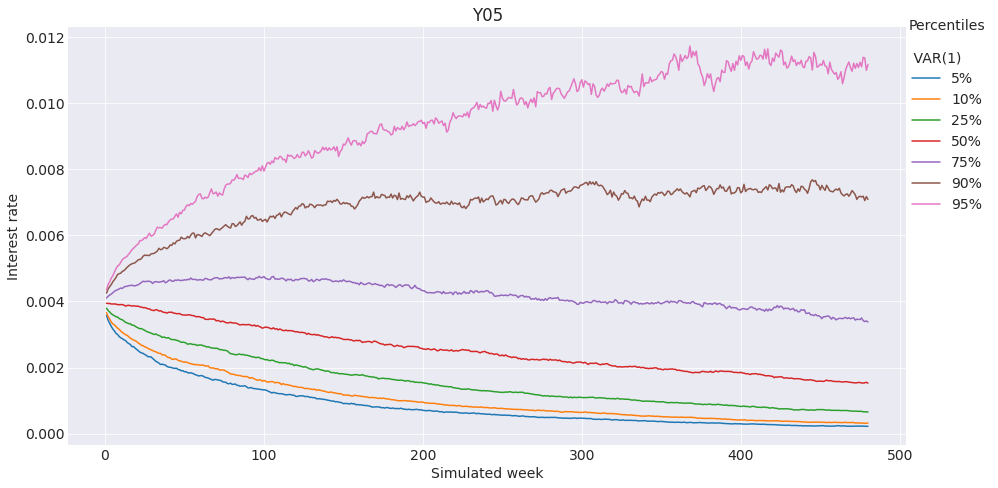

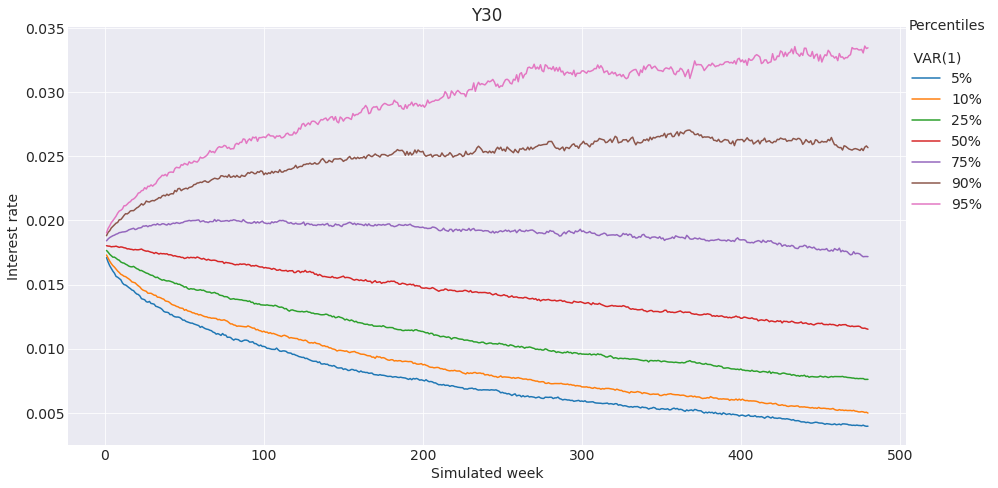

In [38]:
y_labs = ['Stock price', 'Stock price', 'Interest rate', 'Interest rate']
i = 0
for a in asset_labels:
    ax1 = V_prct[a].T.plot()
    plt.ylabel(y_labs[i])
    plt.xlabel('Simulated week')
    handles, labels = ax1.get_legend_handles_labels()
    V_leg = plt.legend(
        handles=handles[:7],
        labels=labels[:7],
        title='Percentiles\n\n VAR(1)',
        bbox_to_anchor=(1.11, 1.05)
    )
    plt.title(f'{a}')

    plt.tight_layout()
    plt.savefig(f'plot/3c_{a}.png', dpi=plt_dpi, bbox_inches='tight')
    plt.show()
    i += 1

In [39]:
# table for week 240 
w = 240 - 1
l_240 = [
    V_prct['CAT'].T.iloc[w],
    V_prct['WMT'].T.iloc[w],
    V_prct['Y05'].T.iloc[w],
    V_prct['Y30'].T.iloc[w]
]
df_240 = pd.concat(l_240, axis=1)
df_240.columns = asset_labels
print('VAR(1) - week 240')
df_240.T

VAR(1) - week 240


,5%,10%,25%,50%,75%,90%,95%
CAT,99.447330,128.672314,197.319311,311.432406,501.865362,752.641733,967.448328
WMT,121.171398,148.960383,188.596839,250.678096,341.319388,448.114312,537.512623
Y05,0.000589,0.000795,0.001298,0.002457,0.004324,0.007102,0.009841
Y30,0.006801,0.007986,0.010387,0.014368,0.019198,0.025363,0.030694


In [40]:
print(df_240.T.to_latex(position='H', caption='Caption.', label='tab:3c_240'))

\begin{table}[H]
\centering
\caption{Caption.}
\label{tab:3c_240}
\begin{tabular}{lrrrrrrr}
\toprule
{} &          5\% &         10\% &         25\% &         50\% &         75\% &         90\% &         95\% \\
\midrule
CAT &   99.447330 &  128.672314 &  197.319311 &  311.432406 &  501.865362 &  752.641733 &  967.448328 \\
WMT &  121.171398 &  148.960383 &  188.596839 &  250.678096 &  341.319388 &  448.114312 &  537.512623 \\
Y05 &    0.000589 &    0.000795 &    0.001298 &    0.002457 &    0.004324 &    0.007102 &    0.009841 \\
Y30 &    0.006801 &    0.007986 &    0.010387 &    0.014368 &    0.019198 &    0.025363 &    0.030694 \\
\bottomrule
\end{tabular}
\end{table}



In [41]:
# table for week 480
w = 480 - 1
l_480 = [
    V_prct['CAT'].T.iloc[w],
    V_prct['WMT'].T.iloc[w],
    V_prct['Y05'].T.iloc[w],
    V_prct['Y30'].T.iloc[w]
]
df_480 = pd.concat(l_480, axis=1)
df_480.columns = asset_labels
print('VAR(1) - week 480')
df_480.T

VAR(1) - week 480


,5%,10%,25%,50%,75%,90%,95%
CAT,108.532055,150.688326,297.788596,572.772618,1097.687764,1967.493343,2876.754509
WMT,162.072699,201.412754,289.794953,448.561587,691.322505,980.555078,1269.200226
Y05,0.000226,0.000322,0.000658,0.001531,0.003379,0.007086,0.011162
Y30,0.003972,0.004995,0.007620,0.011528,0.017186,0.025675,0.033452


In [42]:
print(df_480.T.to_latex(position='H', caption='Caption.', label='tab:3c_480'))

\begin{table}[H]
\centering
\caption{Caption.}
\label{tab:3c_480}
\begin{tabular}{lrrrrrrr}
\toprule
{} &          5\% &         10\% &         25\% &         50\% &          75\% &          90\% &          95\% \\
\midrule
CAT &  108.532055 &  150.688326 &  297.788596 &  572.772618 &  1097.687764 &  1967.493343 &  2876.754509 \\
WMT &  162.072699 &  201.412754 &  289.794953 &  448.561587 &   691.322505 &   980.555078 &  1269.200226 \\
Y05 &    0.000226 &    0.000322 &    0.000658 &    0.001531 &     0.003379 &     0.007086 &     0.011162 \\
Y30 &    0.003972 &    0.004995 &    0.007620 &    0.011528 &     0.017186 &     0.025675 &     0.033452 \\
\bottomrule
\end{tabular}
\end{table}



## 4. Historical simulation

In [43]:
# simple HS
@njit
def HS(hist_dat, n_weeks=480, n_scenarios=2000):
    # set seed for reproducibility
    np.random.seed(np_seed)
    
    K = hist_dat.shape[1]
    n = hist_dat.shape[0]
    res_log = np.zeros((n_scenarios, n_weeks, K))
    for s in np.arange(n_scenarios):
        idx = np.random.choice(n, size=n_weeks, replace=True)
        res_log[s] = hist_dat[idx, :]
    return res_log

In [44]:
# convert HS log returns to stock prices
@njit
def hs2price(res_log, P0):
    n_s, n_w, K = res_log.shape
    res_p = np.zeros((n_s, n_w, K))
    for s in np.arange(n_s):
        res_p[s, 0] = np.exp(res_log[s, 0]) * P0
        for w in np.arange(n_w - 1):
            res_p[s, w + 1] = np.exp(res_log[s, w + 1]) * res_p[s, w]
    return res_p

In [45]:
# historical simulation of log returns
hist_dat = log_market_data.values 
hs_log = HS(hist_dat)
hs_log.shape

(2000, 480, 15)

In [46]:
# convert HS log returns to prices
P0 = market_data.values[-1, :]
hs_p = hs2price(hs_log, P0)
hs_p.shape

(2000, 480, 15)

In [47]:
hs_prct = dict() # dict including each asset
asset_labels = ['CAT', 'WMT', 'Y05', 'Y30']
col_name_idx = np.isin(log_market_data.columns,  asset_labels)
hs_dat = hs_p[:, :, col_name_idx]
qnts = [5, 10, 25, 50, 75, 90, 95]
df_labels = ['5%', '10%', '25%', '50%', '75%', '90%', '95%']
for i in np.arange(np.sum(col_name_idx)):
    d = hs_dat[:, :, i].reshape((n_s, n_w))
    hs_prct[asset_labels[i]] = pd.DataFrame(
        np.percentile(d, q=qnts, axis=0),
        columns=np.arange(1, n_w + 1),
        index=df_labels
    )

In [48]:
# table for week 240 (HS)
w = 240 - 1
hs_240 = [
    hs_prct['CAT'].T.iloc[w],
    hs_prct['WMT'].T.iloc[w],
    hs_prct['Y05'].T.iloc[w],
    hs_prct['Y30'].T.iloc[w]
]
hs_240 = pd.concat(hs_240, axis=1)
hs_240.columns = asset_labels
print('HS - week 240')
hs_240.T

HS - week 240


,5%,10%,25%,50%,75%,90%,95%
CAT,95.317007,126.819357,195.272491,311.099967,506.642829,778.057005,1002.445008
WMT,102.986452,125.259916,173.277295,245.036269,346.565830,471.323087,573.654514
Y05,0.000543,0.000729,0.001338,0.002372,0.004418,0.007876,0.011398
Y30,0.006084,0.007307,0.010025,0.014042,0.019699,0.027281,0.033527


In [49]:
print(hs_240.T.to_latex(position='H', caption='Caption.', label='tab:4_240'))

\begin{table}[H]
\centering
\caption{Caption.}
\label{tab:4_240}
\begin{tabular}{lrrrrrrr}
\toprule
{} &          5\% &         10\% &         25\% &         50\% &         75\% &         90\% &          95\% \\
\midrule
CAT &   95.317007 &  126.819357 &  195.272491 &  311.099967 &  506.642829 &  778.057005 &  1002.445008 \\
WMT &  102.986452 &  125.259916 &  173.277295 &  245.036269 &  346.565830 &  471.323087 &   573.654514 \\
Y05 &    0.000543 &    0.000729 &    0.001338 &    0.002372 &    0.004418 &    0.007876 &     0.011398 \\
Y30 &    0.006084 &    0.007307 &    0.010025 &    0.014042 &    0.019699 &    0.027281 &     0.033527 \\
\bottomrule
\end{tabular}
\end{table}



In [50]:
# table for week 480 (HS)
w = 480 - 1
hs_480 = [
    hs_prct['CAT'].T.iloc[w],
    hs_prct['WMT'].T.iloc[w],
    hs_prct['Y05'].T.iloc[w],
    hs_prct['Y30'].T.iloc[w]
]
hs_480 = pd.concat(hs_480, axis=1)
hs_480.columns = asset_labels
print('HS - week 480')
hs_480.T

HS - week 480


,5%,10%,25%,50%,75%,90%,95%
CAT,106.741275,150.419795,277.480613,557.331530,1103.157266,2169.283683,3026.923899
WMT,123.542280,159.037517,255.668441,414.333218,689.781330,1096.892499,1491.377540
Y05,0.000164,0.000274,0.000596,0.001512,0.003670,0.008322,0.012373
Y30,0.003207,0.004320,0.006862,0.011230,0.017681,0.027776,0.035373


In [51]:
print(hs_480.T.to_latex(position='H', caption='Caption.', label='tab:4_480'))

\begin{table}[H]
\centering
\caption{Caption.}
\label{tab:4_480}
\begin{tabular}{lrrrrrrr}
\toprule
{} &          5\% &         10\% &         25\% &         50\% &          75\% &          90\% &          95\% \\
\midrule
CAT &  106.741275 &  150.419795 &  277.480613 &  557.331530 &  1103.157266 &  2169.283683 &  3026.923899 \\
WMT &  123.542280 &  159.037517 &  255.668441 &  414.333218 &   689.781330 &  1096.892499 &  1491.377540 \\
Y05 &    0.000164 &    0.000274 &    0.000596 &    0.001512 &     0.003670 &     0.008322 &     0.012373 \\
Y30 &    0.003207 &    0.004320 &    0.006862 &    0.011230 &     0.017681 &     0.027776 &     0.035373 \\
\bottomrule
\end{tabular}
\end{table}



In [52]:
print(df_240.T.to_latex(position='H', caption='Caption.', label='tab:3c_240'))

\begin{table}[H]
\centering
\caption{Caption.}
\label{tab:3c_240}
\begin{tabular}{lrrrrrrr}
\toprule
{} &          5\% &         10\% &         25\% &         50\% &         75\% &         90\% &         95\% \\
\midrule
CAT &   99.447330 &  128.672314 &  197.319311 &  311.432406 &  501.865362 &  752.641733 &  967.448328 \\
WMT &  121.171398 &  148.960383 &  188.596839 &  250.678096 &  341.319388 &  448.114312 &  537.512623 \\
Y05 &    0.000589 &    0.000795 &    0.001298 &    0.002457 &    0.004324 &    0.007102 &    0.009841 \\
Y30 &    0.006801 &    0.007986 &    0.010387 &    0.014368 &    0.019198 &    0.025363 &    0.030694 \\
\bottomrule
\end{tabular}
\end{table}



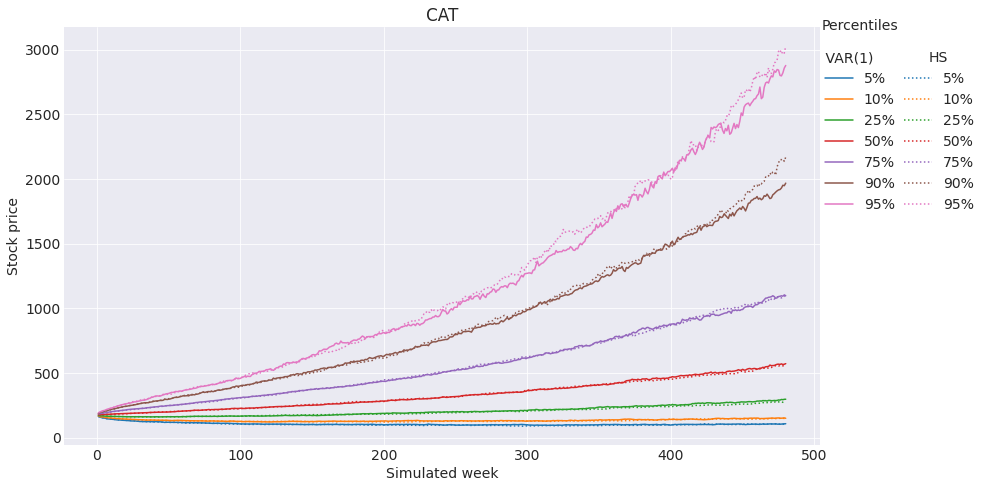

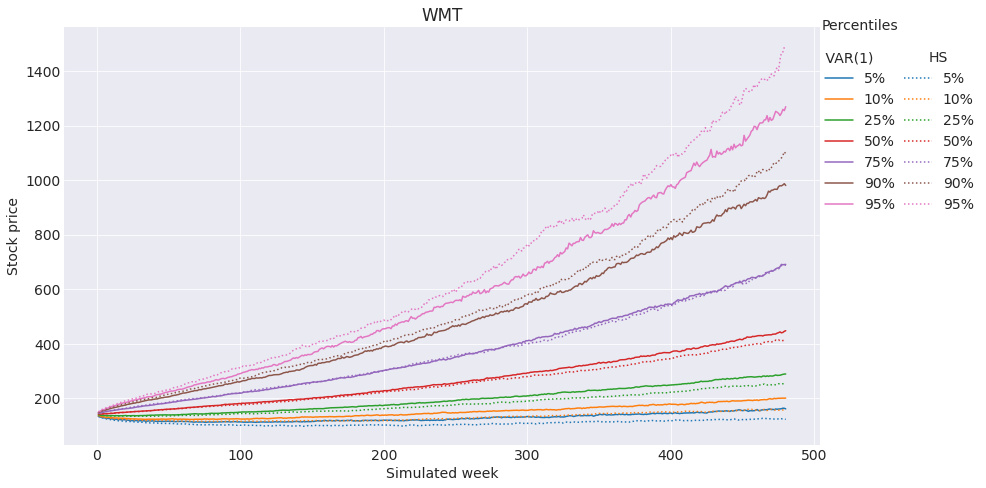

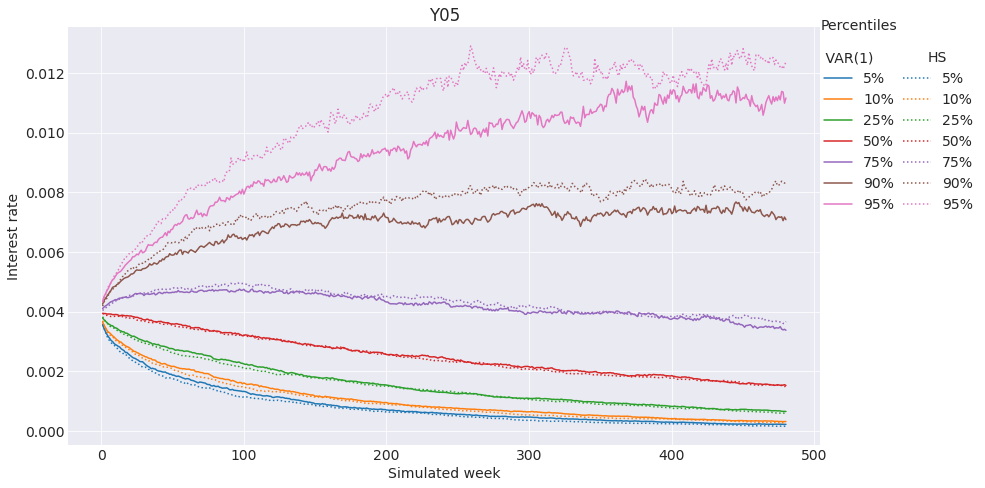

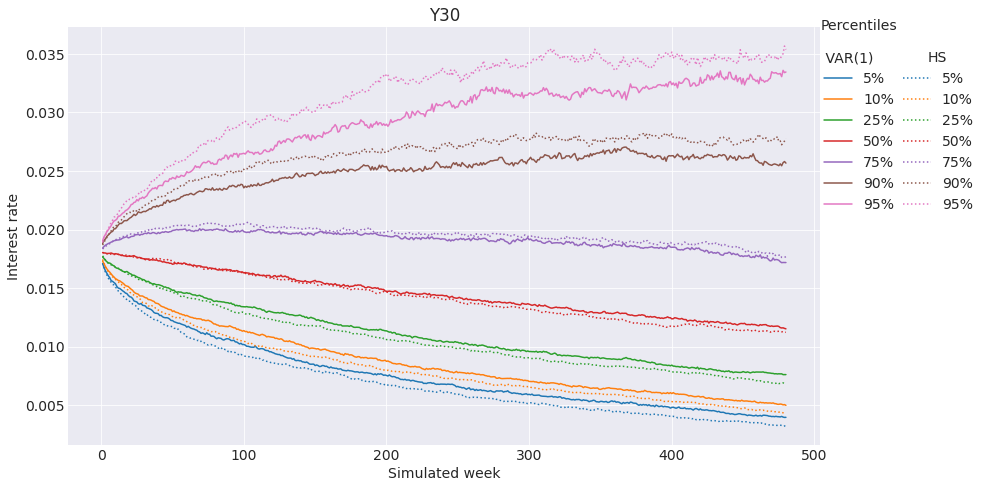

In [53]:
pal = sns.color_palette()
col = pal.as_hex()[:7]
y_labs = ['Stock price', 'Stock price', 'Interest rate', 'Interest rate']
i = 0
for a in asset_labels:
    ax1 = V_prct[a].T.plot(color=col)
    hs_prct[a].T.plot(ax=ax1, linestyle='dotted', color=col)
    plt.ylabel(y_labs[i])
    plt.xlabel('Simulated week')

    handles, labels = ax1.get_legend_handles_labels()
    V_leg = plt.legend(
        handles=handles[:7],
        labels=labels[:7],
        title='Percentiles\n\n VAR(1)',
        bbox_to_anchor=(1.12, 1.05)
    )
    plt.gca().add_artist(V_leg)
    
    hs_leg = plt.legend(
        handles=handles[7:14],
        labels=labels[7:14],
        title='\n\nHS',
        bbox_to_anchor=(1.22, 1.05)
    )
    plt.title(f'{a}')
    plt.tight_layout()
    plt.savefig(f'plot/4_{a}.png', dpi=plt_dpi, bbox_inches='tight')
    plt.show()
    i += 1

## 5. VAR(1)-DCC-model

### a) Compute ACF

In [54]:
# extract residuals for Caterpillar stock
CAT_resid = resid[1, :]
CAT_resid.shape

(1303,)

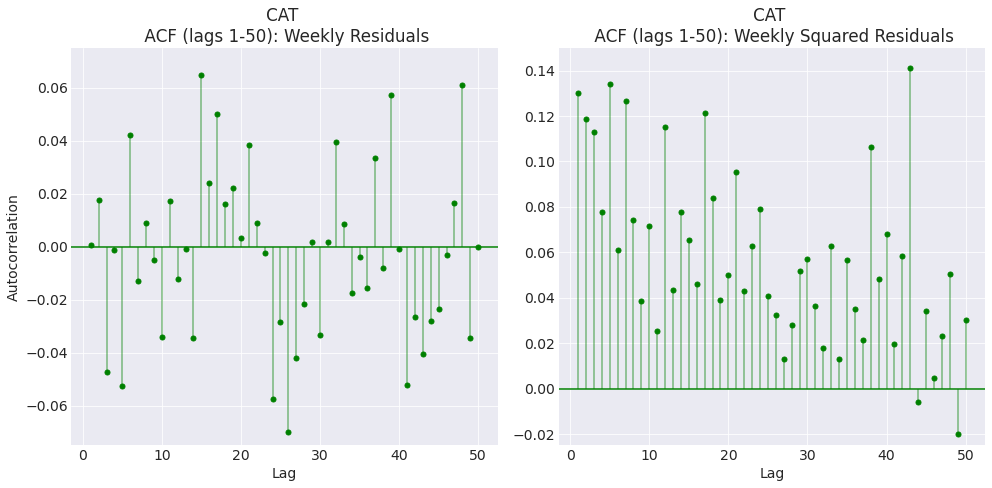

In [55]:
# ACF for residuals - CAT
fig, (ax1, ax2) = plt.subplots(1, 2)
plot_acf(
    CAT_resid,
    lags=50,
    zero=False,
    alpha=None,
    title='CAT \n ACF (lags 1-50): Weekly Residuals',
    color='green', 
    vlines_kwargs={'colors': 'green', 'alpha': .5},
    ax=ax1
)
ax1.set_xlabel('Lag')
ax1.set_ylabel('Autocorrelation')
ax1.set_ylim([-.075, .075])

# ACF for squared residuals - CAT
plot_acf(
    np.square(CAT_resid),
    lags=50,
    zero=False,
    alpha=None,
    title='CAT \n ACF (lags 1-50): Weekly Squared Residuals',
    color='green', 
    vlines_kwargs={'colors': 'green', 'alpha': .5},
    ax=ax2
)

ax2.set_ylim([-.025, .15])
ax2.set_xlabel('Lag')
plt.tight_layout()
plt.savefig('plot/5a_CAT.png', dpi=plt_dpi)
plt.show()

In [56]:
# extract residuals for 5-year interest rate
Y05_resid = resid[10, :]
Y05_resid.shape

(1303,)

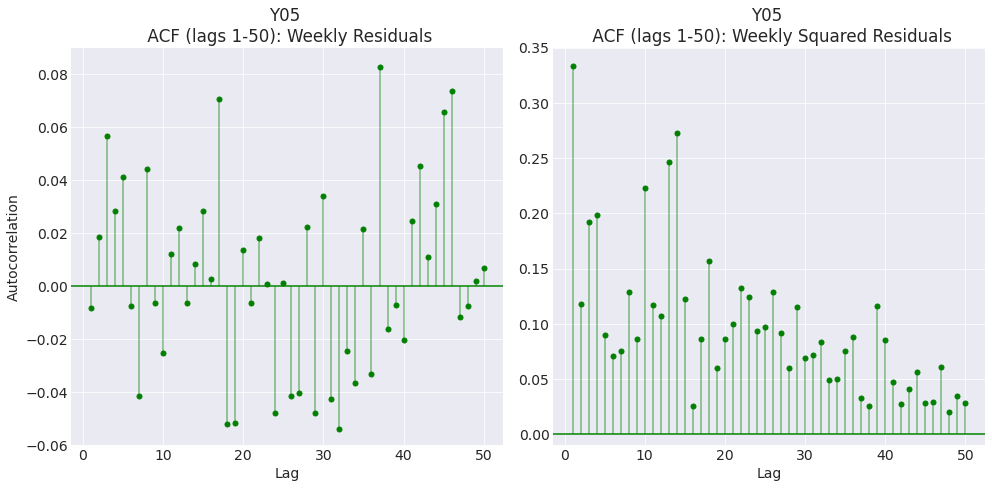

In [57]:
# ACF for residuals - Y05
fig, (ax1, ax2) = plt.subplots(1, 2)
plot_acf(
    Y05_resid,
    lags=50,
    zero=False,
    alpha=None,
    title='Y05 \n ACF (lags 1-50): Weekly Residuals',
    color='green', 
    vlines_kwargs={'colors': 'green', 'alpha': .5},
    ax=ax1
)
ax1.set_xlabel('Lag')
ax1.set_ylabel('Autocorrelation')
ax1.set_ylim([-.06, .09])

# ACF for squared residuals - Y05
plot_acf(
    np.square(Y05_resid),
    lags=50,
    zero=False,
    alpha=None,
    title='Y05 \n ACF (lags 1-50): Weekly Squared Residuals',
    color='green', 
    vlines_kwargs={'colors': 'green', 'alpha': .5},
    ax=ax2
)

ax2.set_ylim([-.01, .35])
ax2.set_xlabel('Lag')

plt.tight_layout()
plt.savefig('plot/5a_Y05.png', dpi=plt_dpi)
plt.show()

### b) Estimate VAR(1)-DCC

In [58]:
def garch_constr(x):
    return 1 - x[1] - x[2]

In [59]:
# create GARCH object
class GARCH(object):
    def __init__(self, log_ret):
        self.log_ret = log_ret * 100
        self.params = self.optimize()
        fitted_var = self.get_recursions(self.params, self.log_ret)
        df = pd.DataFrame(np.sqrt(fitted_var) / 100, columns=['GARCH'])
        self.vol = df
        self.residuals = log_ret.values.reshape(self.vol.shape) / self.vol.values
        self.fcst_params = (self.log_ret[-1], fitted_var[-1])

    def optimize(self):
        con = {
            'type': 'ineq',
            'fun': garch_constr
        }
        init_params = (.1, .05, .92)
        params = minimize(
            fun=self.loglik,
            x0=init_params,
            args=(self.log_ret),
            bounds=(
                (.0001, None), # omega
                (.0001, 1), # alpha
                (.0001, 1) # beta
            ),
            constraints=con
        )
        return params.x

    def get_recursions(self, params, log_ret, forecast=False):
        omega, alpha, beta = params
        T = log_ret.shape[0]
        var = np.zeros(T)

        if forecast:
            # forecasting: set initial variance and initial log return 
            # to the last of the calibration period, i.e., self.fcst_params
            log_ret = np.insert(log_ret.values, 0, self.fcst_params[0])
            var = np.insert(var, 0, self.fcst_params[1])
        else:
            # estimation: set initial variance as the sample variance
            var[0] = log_ret.var() # sample variance

        for i in np.arange(1, T):
            var[i] = omega + alpha * np.square(log_ret[i-1]) + beta * var[i-1]
        return var

    def loglik(self, params, log_ret):
        var = self.get_recursions(params, log_ret)
        loglik_fun = np.sum(np.log(var) + np.square(log_ret) / var)
        return loglik_fun # negative due to minimization problem

    def forecast(self, params, log_ret):
        res = self.get_recursions(params, log_ret * 100, forecast=True)[1:]
        df = pd.DataFrame(np.sqrt(res) / 100, columns=['GARCH'])
        return df

In [60]:
def GD_loglik(params, z_hat, R):
    n = z_hat.shape[0]
    K = z_hat.shape[1]
    Q_t = np.zeros((n, K, K))
    log_lik = np.zeros(n - 1)
    delta, gamma = params
    z = z_hat.reshape((n, K, 1))
    Q_t[0] = R

    for i in np.arange(1, n):
        z_prev = z[i - 1]
        Q_t[i] = (1 - delta - gamma) * R + delta * z_prev @ z_prev.T + gamma * Q_t[i - 1]
        Q_t_norm = np.sqrt(np.diag(np.diag(Q_t[i])))
        R_t = np.linalg.inv(Q_t_norm) @ Q_t[i] @ np.linalg.inv(Q_t_norm)

        # compute log-likelihood element
        z_hat_t = z_hat[i, :].reshape((1, K))
        log_lik[i - 1] = np.log(np.linalg.det(R_t)) + z_hat_t @ np.linalg.inv(R_t) @ z_hat_t.T
    return np.sum(log_lik)

In [61]:
# constraint: delta + gamma < 1
def GD_constr(x):
    return 1 - x[0] - x[1]

In [62]:
# optimize gamma and delta log-likelihood
def GD_optimize(z, R):
    con = {
        'type': 'ineq',
        'fun': GD_constr
    }
    init_params = (.2, .6) # based on FCF course book
    params = minimize(
        fun=GD_loglik,
        x0=init_params,
        args=(z, R),
        bounds=((.001, 1), (.001, 1)),
        constraints=con
    )
    print(params)
    return params

In [63]:
# demean log returns
y = log_market_data
y_dm = y - y.mean(axis=0)
y_dm.shape

(1304, 15)

In [169]:
# fit GARCH(1,1)-model for each asset
K = y_dm.shape[1]
n = y_dm.shape[0]
assets = y_dm.columns
g_params = np.zeros((K, 3))
g_vol = np.zeros((K, n))
g_residuals = np.zeros((K, n))
for i in np.arange(K):
    d = y_dm[assets[i]]
    mdl = GARCH(d)
    g_params[i, :] = mdl.params
    g_vol[i, :] = mdl.vol.values.flatten()
    g_residuals[i, :] = mdl.residuals.flatten()
g_residuals = g_residuals.T.copy() # transpose to align with therotecial notation
g_vol = g_vol.T.copy() # transpose to align with therotecial notation
g_params[:, 0] = g_params[:, 0] / 10000 # convert to numerical scale

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


In [170]:
# compute R matrix
R = np.corrcoef(g_residuals.T)
R.shape

(15, 15)

In [171]:
# for report use - 5b) R-matrix
print(pd.DataFrame(R).round(4).to_latex(index=False, header=False))

\begin{tabular}{rrrrrrrrrrrrrrr}
\toprule
1.0000 & 0.4459 & 0.3459 & 0.3973 & 0.3963 & 0.4391 & 0.2864 & 0.3021 & 0.2757 & 0.4168 & 0.2397 & 0.1986 & 0.1754 & 0.1711 & 0.1804 \\
0.4459 & 1.0000 & 0.2733 & 0.3971 & 0.4755 & 0.5183 & 0.3240 & 0.3078 & 0.2851 & 0.4906 & 0.3000 & 0.2864 & 0.2786 & 0.2812 & 0.2736 \\
0.3459 & 0.2733 & 1.0000 & 0.3628 & 0.3388 & 0.4064 & 0.3131 & 0.3870 & 0.3539 & 0.4111 & 0.0995 & 0.0639 & 0.0526 & 0.0584 & 0.0613 \\
0.3973 & 0.3971 & 0.3628 & 1.0000 & 0.4776 & 0.4173 & 0.3848 & 0.3681 & 0.3188 & 0.4117 & 0.2706 & 0.2261 & 0.2044 & 0.2038 & 0.2123 \\
0.3963 & 0.4755 & 0.3388 & 0.4776 & 1.0000 & 0.4355 & 0.3766 & 0.3717 & 0.3227 & 0.4048 & 0.3208 & 0.2941 & 0.2770 & 0.2687 & 0.2504 \\
0.4391 & 0.5183 & 0.4064 & 0.4173 & 0.4355 & 1.0000 & 0.3176 & 0.3537 & 0.3281 & 0.4764 & 0.2434 & 0.2127 & 0.1948 & 0.1941 & 0.2010 \\
0.2864 & 0.3240 & 0.3131 & 0.3848 & 0.3766 & 0.3176 & 1.0000 & 0.3056 & 0.3300 & 0.3176 & 0.2187 & 0.1854 & 0.1687 & 0.1711 & 0.1812 \\
0.3021

In [172]:
# for report use - 5b) GARCH(1,1)-parameters
print(pd.DataFrame(
    g_params, index=[assets]).to_latex(
    position='H', header=['$\omega$', '$\ alpha$', '$\ beta$'],
    caption='Table.', label='tab:5b_garch' 
))

\begin{table}[H]
\centering
\caption{Table.}
\label{tab:5b_garch}
\begin{tabular}{lrrr}
\toprule
    &  \$\textbackslash omega\$ & \$\textbackslash  alpha\$ &  \$\textbackslash  beta\$ \\
\midrule
BA &  0.000146 &  0.183661 &  0.769091 \\
CAT &  0.000055 &  0.061823 &  0.912054 \\
KO &  0.000024 &  0.096495 &  0.882944 \\
DIS &  0.000069 &  0.119392 &  0.840721 \\
JPM &  0.000048 &  0.122013 &  0.860905 \\
MMM &  0.000016 &  0.056727 &  0.929890 \\
MSFT &  0.000033 &  0.065300 &  0.913718 \\
PFE &  0.000015 &  0.036509 &  0.951920 \\
WMT &  0.000015 &  0.047284 &  0.937266 \\
XOM &  0.000074 &  0.163079 &  0.772752 \\
Y05 &  0.000013 &  0.100761 &  0.899239 \\
Y10 &  0.000012 &  0.106489 &  0.893511 \\
Y15 &  0.000013 &  0.105019 &  0.889774 \\
Y20 &  0.000011 &  0.102909 &  0.890460 \\
Y30 &  0.000019 &  0.131900 &  0.853995 \\
\bottomrule
\end{tabular}
\end{table}



In [173]:
delta, gamma = GD_optimize(g_residuals, R).x

<ipython-input-165-74c88f971479>:18: RuntimeWarning: invalid value encountered in log
  log_lik[i - 1] = np.log(np.linalg.det(R_t)) + z_hat_t @ np.linalg.inv(R_t) @ z_hat_t.T
<ipython-input-165-74c88f971479>:13: RuntimeWarning: invalid value encountered in sqrt
  Q_t_norm = np.sqrt(np.diag(np.diag(Q_t[i])))
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/numpy/linalg/linalg.py:2158: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


     fun: -2870.183389504647
     jac: array([-0.0451355 , -0.02011108])
 message: 'Optimization terminated successfully'
    nfev: 70
     nit: 20
    njev: 18
  status: 0
 success: True
       x: array([0.01688221, 0.96656018])


In [174]:
# for report use - 5b) delta, gamma
print(pd.DataFrame([delta, gamma]).round(4).T.to_latex(
    position='H', index=False, header=['$\delta$', '$\ gamma$'],
    caption='Table.', label='tab:5b_delta-gamma' 
))

\begin{table}[H]
\centering
\caption{Table.}
\label{tab:5b_delta-gamma}
\begin{tabular}{rr}
\toprule
\$\textbackslash delta\$ & \$\textbackslash  gamma\$ \\
\midrule
  0.0169 &    0.9666 \\
\bottomrule
\end{tabular}
\end{table}



### c) Create percentile plots for VAR(1)-DCC, along with the VAR(1) and HS

In [175]:
def get_Q0(delta, gamma, z, R):
    n = z.shape[0]
    K = z.shape[1]
    Q_t = np.zeros((n, K, K))
    z_hat = z.reshape((n, K, 1)).copy()
    Q_t[0] = R
    for i in np.arange(1, n):
        z_prev = z_hat[i - 1]
        Q_t[i] = (1 - delta - gamma) * R + delta * z_prev @ z_prev.T + gamma * Q_t[i - 1]
    return Q_t[-1]

In [176]:
@njit
def D_recursion(D_params, e_t, D_t):
    omega, alpha, beta = D_params
    res = omega + alpha * np.square(e_t) + beta * np.square(np.diag(D_t))
    return np.diag(np.sqrt(res))

In [177]:
# not in use
@njit
def D_recursion_brute(D_params, e_t, D_t):
    K = 15
    omega, alpha, beta = D_params
    res = np.zeros((K, K))
    d_t = np.diag(D_t)
    for i in np.arange(K):
        res[i, i] = np.sqrt(omega[i] + alpha[i] * np.square(e_t[i]) + beta[i] * np.square(d_t[i]))
    return res

In [178]:
@njit
def Q_recursion(delta, gamma, z_t, Q_t, R):
    return (1 - delta - gamma) * R + delta * z_t @ z_t.T + gamma * Q_t

In [179]:
@njit
def Q_norm_inv(Q_t):
    return np.linalg.inv(np.sqrt(np.diag(np.diag(Q_t))))

In [180]:
@njit
def get_z(D_t, e_t):
    return np.linalg.inv(D_t) @ e_t

In [181]:
@njit
def VAR_DCC(delta, gamma, B, R, Z, g_params, init_params, n_scenarios=2000, n_weeks=480):
    e0, D0, Q0, P0, Y0 = init_params
    D_params = g_params[:, 0], g_params[:, 1], g_params[:, 2] # GARCH-params
    K = resid.shape[0] # number of assets
    log_mat = np.zeros((n_scenarios, n_weeks, K, 1)) # log returns
    p_mat = np.zeros((n_scenarios, n_weeks, K, 1)) # prices
    A0, A1 = B # VAR(1)-params

    z0 = get_z(D0, e0)
    Q1 = Q_recursion(delta, gamma, z0, Q0, R)
    Q1_norm_inv = Q_norm_inv(Q1)
    R1 = Q1_norm_inv @ Q1 @ Q1_norm_inv
    D1 = D_recursion(D_params, e0.flatten(), D0)
    S1 = D1 @ R1 @ D1
    C1 = np.linalg.cholesky(S1)
    
    for s in np.arange(n_scenarios):
        # allocate memory for each scenario
        D_t = np.zeros((n_weeks, K, K))
        Q_t = np.zeros((n_weeks, K, K))
        R_t = np.zeros((n_weeks, K, K))
        e_t = np.zeros((n_weeks, K, 1))

        # set initial params
        Q_t[0], D_t[0], R_t[0] = Q1, D1, R1
        e_t[0] = C1 @ Z[s, 0]
        log_mat[s, 0] =  A0 + A1 @ Y0 + e_t[0]
        p_mat[s, 0] = np.exp(log_mat[s, 0]) * P0
    
        for w in np.arange(1, n_weeks):
            z_t = get_z(D_t[w - 1], e_t[w - 1])
            Q_t[w] = Q_recursion(delta, gamma, z_t, Q_t[w - 1], R)
            Q_t_norm_inv = Q_norm_inv(Q_t[w])
            R_t[w] = Q_t_norm_inv @ Q_t[w] @ Q_t_norm_inv
            D_t[w] = D_recursion(D_params, e_t[w - 1].flatten(), D_t[w - 1])
            C_t = np.linalg.cholesky(D_t[w] @ R_t[w] @ D_t[w])
            e_t[w] = C_t @ Z[s, w]
            log_mat[s, w] = A0 + A1 @ log_mat[s, w - 1] + e_t[w]
            p_mat[s, w] =  np.exp(log_mat[s, w]) * p_mat[s, w - 1]
    return log_mat, p_mat

In [182]:
# set seed for reproducibility
np.random.seed(np_seed)
K = 15 # number of assets
n_s = 2000 # number of scenarios
n_w = 480 # number of weeks
Y0 = log_market_data.values[-1, :].reshape((K, 1)).copy() # initial returns
P0 = market_data.values[-1, :].reshape((K, 1)).copy() # initial prices
B = (A0.copy(), A1.copy()) # VAR(1)-parameters
Z = np.random.standard_normal((n_s, n_w, K, 1)) # standard-normal matrix

# compute initial Q0, D0 and e0
Q0 = get_Q0(delta, gamma, g_residuals, R)
D0 = np.diag(g_vol[-1])
e0 = resid[:, -1].reshape((K, 1)).copy()
init_params = e0, D0, Q0, P0, Y0

In [183]:
pd.DataFrame(R)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,1.000000,0.445933,0.345946,0.397327,0.396259,0.439097,0.286433,0.302066,0.275713,0.416785,0.239687,0.198597,0.175354,0.171105,0.180387
1,0.445933,1.000000,0.273261,0.397109,0.475549,0.518325,0.324013,0.307758,0.285095,0.490589,0.299983,0.286436,0.278568,0.281162,0.273613
2,0.345946,0.273261,1.000000,0.362832,0.338755,0.406428,0.313111,0.387028,0.353859,0.411076,0.099477,0.063853,0.052610,0.058367,0.061290
3,0.397327,0.397109,0.362832,1.000000,0.477591,0.417309,0.384828,0.368107,0.318764,0.411744,0.270630,0.226081,0.204403,0.203837,0.212338
4,0.396259,0.475549,0.338755,0.477591,1.000000,0.435480,0.376608,0.371748,0.322665,0.404766,0.320837,0.294095,0.277000,0.268733,0.250403
5,0.439097,0.518325,0.406428,0.417309,0.435480,1.000000,0.317641,0.353695,0.328149,0.476399,0.243371,0.212703,0.194792,0.194095,0.201041
6,0.286433,0.324013,0.313111,0.384828,0.376608,0.317641,1.000000,0.305622,0.330044,0.317644,0.218673,0.185350,0.168749,0.171110,0.181196
7,0.302066,0.307758,0.387028,0.368107,0.371748,0.353695,0.305622,1.000000,0.341738,0.403972,0.100230,0.080844,0.076572,0.086323,0.104102
8,0.275713,0.285095,0.353859,0.318764,0.322665,0.328149,0.330044,0.341738,1.000000,0.284975,0.126224,0.098997,0.090842,0.094512,0.099952
9,0.416785,0.490589,0.411076,0.411744,0.404766,0.476399,0.317644,0.403972,0.284975,1.000000,0.247975,0.213010,0.198585,0.200910,0.217161


In [184]:
# perform VAR(1)-DCC simulation
sim_log_VD, sim_p_VD = VAR_DCC(delta, gamma, B, R, Z, g_params, init_params)

In [185]:
# get index for requested assets
VD_prct = dict() # dict including each asset
asset_labels = ['CAT', 'WMT', 'Y05', 'Y30']
col_name_idx = np.isin(log_market_data.columns, asset_labels)
prc_dat_VD = sim_p_VD[:, :, col_name_idx]
qnts = [5, 10, 25, 50, 75, 90, 95]
df_labels = ['5%', '10%', '25%', '50%', '75%', '90%', '95%']
for i in np.arange(np.sum(col_name_idx)):
    d = prc_dat_VD[:, :, i].reshape((n_s, n_w))
    VD_prct[asset_labels[i]] = pd.DataFrame(
        np.percentile(d, q=qnts, axis=0),
        columns=np.arange(1, n_w + 1),
        index=df_labels
    )

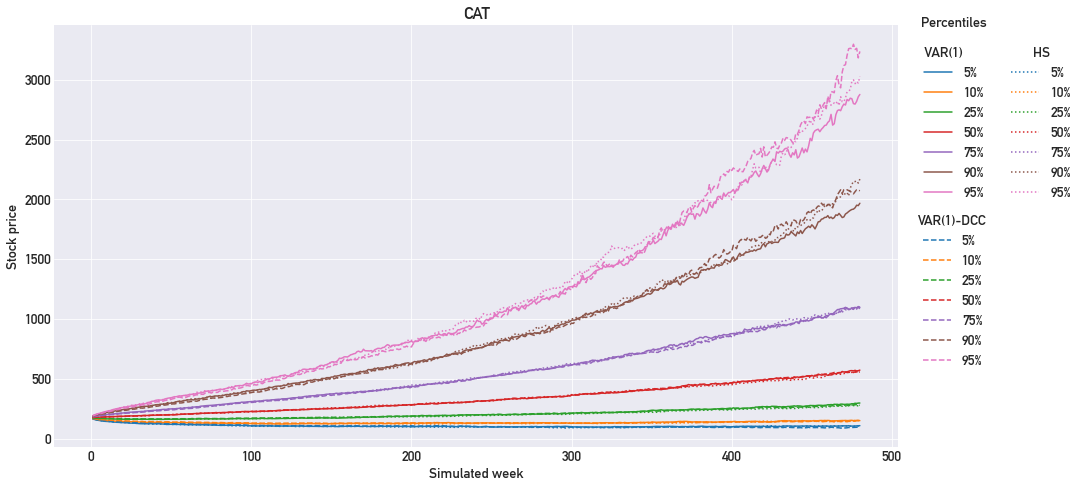

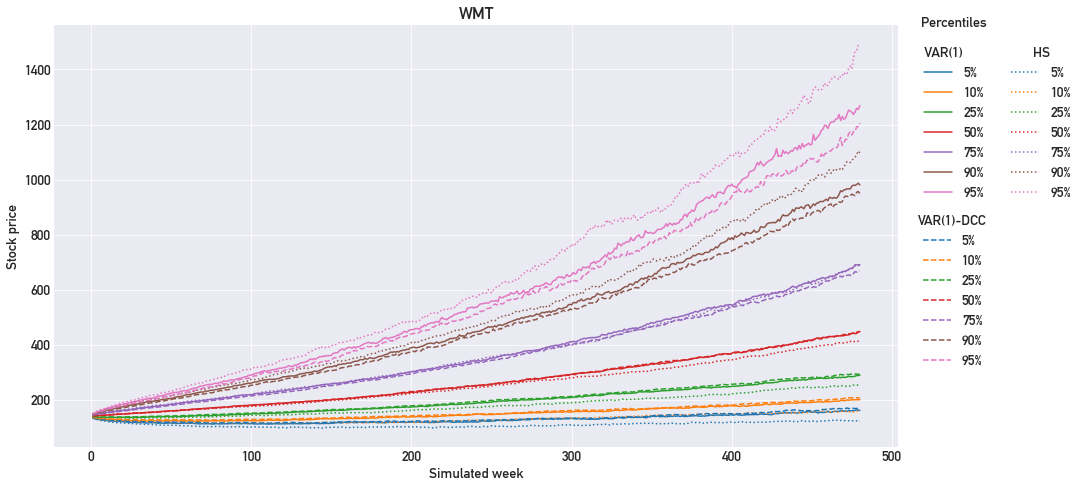

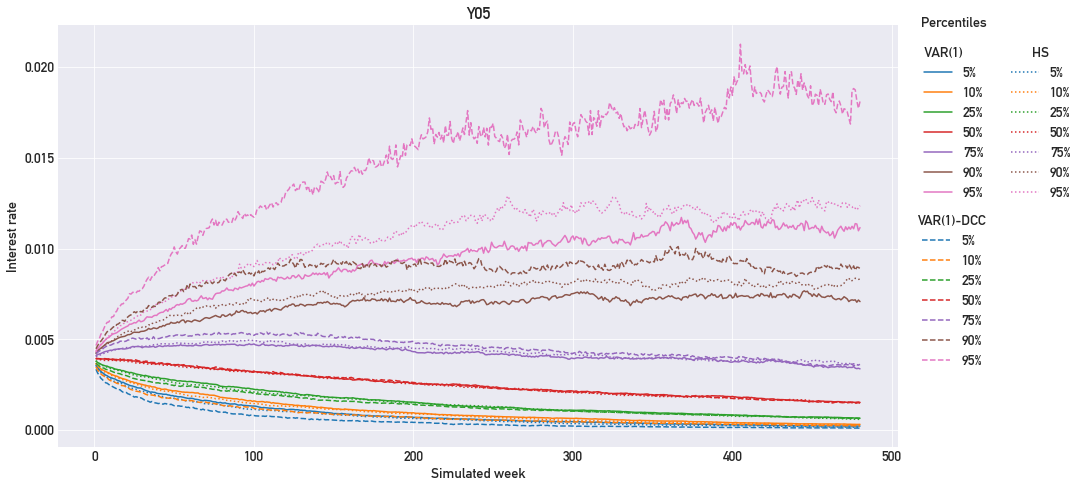

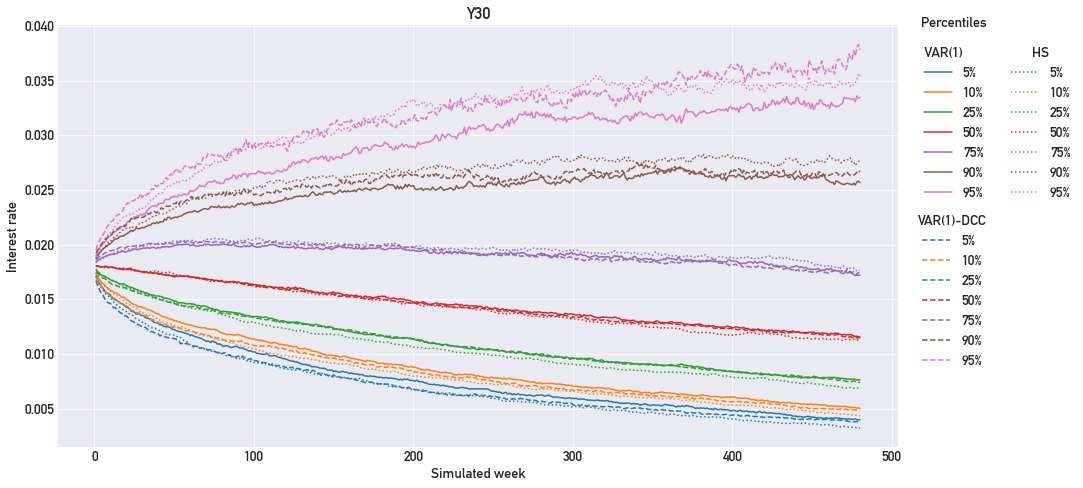

In [186]:
pal = sns.color_palette()
col = pal.as_hex()[:7]
y_labs = ['Stock price', 'Stock price', 'Interest rate', 'Interest rate']
i = 0
for a in asset_labels:
    ax1 = V_prct[a].T.plot(color=col) # VAR(1)
    hs_prct[a].T.plot(ax=ax1, linestyle='dotted', color=col) # HS
    VD_prct[a].T.plot(ax=ax1, linestyle='dashed', color=col) # VAR(1)-DCC

    handles, labels = ax1.get_legend_handles_labels()
    V_leg = plt.legend(
        handles=handles[:7],
        labels=labels[:7],
        title='Percentiles\n\n VAR(1)',
        bbox_to_anchor=(1.12, 1.05)
    )
    plt.gca().add_artist(V_leg)
    hs_leg = plt.legend(
        handles=handles[7:14],
        labels=labels[:7],
        title='\n\nHS',
        bbox_to_anchor=(1.22, 1.05)
    )
    plt.gca().add_artist(hs_leg)
    VD_leg = plt.legend(
        handles=handles[14:],
        labels=labels[:7],
        title='VAR(1)-DCC',
        bbox_to_anchor=(1.12, .58)
    )
    plt.ylabel(y_labs[i])
    plt.xlabel('Simulated week')
    plt.title(f'{a}')
    plt.tight_layout()
    plt.savefig(f'plot/5c_{a}.png', dpi=plt_dpi, bbox_inches='tight')
    i += 1

In [187]:
# table for week 480
w = 240 - 1
VD_240 = [
    VD_prct['CAT'].T.iloc[w],
    VD_prct['WMT'].T.iloc[w],
    VD_prct['Y05'].T.iloc[w],
    VD_prct['Y30'].T.iloc[w]
]
VD_240 = pd.concat(VD_240, axis=1)
VD_240.columns = asset_labels
print('VAR(1)-DCC - week 240')
VD_240.T

VAR(1)-DCC - week 240


,5%,10%,25%,50%,75%,90%,95%
CAT,101.945857,130.389484,199.425379,312.035455,498.854278,756.931578,929.661571
WMT,126.277423,148.558450,194.139826,252.856329,336.132386,436.419033,511.999226
Y05,0.000336,0.000580,0.001224,0.002390,0.004654,0.009226,0.015809
Y30,0.006222,0.007681,0.010561,0.014233,0.019019,0.026304,0.032760


In [188]:
# report use - 5c) week 240
print(VD_240.T.to_latex(position='H', caption='Caption.', label='tab:5_240'))

\begin{table}[H]
\centering
\caption{Caption.}
\label{tab:5_240}
\begin{tabular}{lrrrrrrr}
\toprule
{} &          5\% &         10\% &         25\% &         50\% &         75\% &         90\% &         95\% \\
\midrule
CAT &  101.945857 &  130.389484 &  199.425379 &  312.035455 &  498.854278 &  756.931578 &  929.661571 \\
WMT &  126.277423 &  148.558450 &  194.139826 &  252.856329 &  336.132386 &  436.419033 &  511.999226 \\
Y05 &    0.000336 &    0.000580 &    0.001224 &    0.002390 &    0.004654 &    0.009226 &    0.015809 \\
Y30 &    0.006222 &    0.007681 &    0.010561 &    0.014233 &    0.019019 &    0.026304 &    0.032760 \\
\bottomrule
\end{tabular}
\end{table}



In [189]:
# table for week 480
w = 480 - 1
VD_480 = [
    VD_prct['CAT'].T.iloc[w],
    VD_prct['WMT'].T.iloc[w],
    VD_prct['Y05'].T.iloc[w],
    VD_prct['Y30'].T.iloc[w]
]
VD_480 = pd.concat(VD_480, axis=1)
VD_480.columns = asset_labels
print('VAR(1)-DCC - week 480')
VD_480.T

VAR(1)-DCC - week 480


,5%,10%,25%,50%,75%,90%,95%
CAT,95.859934,151.548292,278.321525,565.118219,1085.710323,2071.554626,3236.628570
WMT,170.697232,206.532130,292.423828,449.489976,668.463976,948.870987,1205.592761
Y05,0.000114,0.000242,0.000650,0.001492,0.003626,0.008908,0.018117
Y30,0.003728,0.004783,0.007393,0.011469,0.017366,0.026634,0.037821


In [190]:
# report use - 5c) week 480
print(VD_480.T.to_latex(position='H', caption='Caption.', label='tab:5_480'))

\begin{table}[H]
\centering
\caption{Caption.}
\label{tab:5_480}
\begin{tabular}{lrrrrrrr}
\toprule
{} &          5\% &         10\% &         25\% &         50\% &          75\% &          90\% &          95\% \\
\midrule
CAT &   95.859934 &  151.548292 &  278.321525 &  565.118219 &  1085.710323 &  2071.554626 &  3236.628570 \\
WMT &  170.697232 &  206.532130 &  292.423828 &  449.489976 &   668.463976 &   948.870987 &  1205.592761 \\
Y05 &    0.000114 &    0.000242 &    0.000650 &    0.001492 &     0.003626 &     0.008908 &     0.018117 \\
Y30 &    0.003728 &    0.004783 &    0.007393 &    0.011469 &     0.017366 &     0.026634 &     0.037821 \\
\bottomrule
\end{tabular}
\end{table}



In [ ]:
print(df_240.T.to_latex(position='H', caption='Caption.', label='tab:3c_240'))

\begin{table}[H]
\centering
\caption{Caption.}
\label{tab:3c_240}
\begin{tabular}{lrrrrrrr}
\toprule
{} &          5\% &         10\% &         25\% &         50\% &         75\% &         90\% &         95\% \\
\midrule
CAT &   99.447330 &  128.672314 &  197.319311 &  311.432406 &  501.865362 &  752.641733 &  967.448328 \\
WMT &  121.171398 &  148.960383 &  188.596839 &  250.678096 &  341.319388 &  448.114312 &  537.512623 \\
Y05 &    0.000589 &    0.000795 &    0.001298 &    0.002457 &    0.004324 &    0.007102 &    0.009841 \\
Y30 &    0.006801 &    0.007986 &    0.010387 &    0.014368 &    0.019198 &    0.025363 &    0.030694 \\
\bottomrule
\end{tabular}
\end{table}

